<a href="https://colab.research.google.com/github/DuilioSM/crabi_data_analyst/blob/main/crabi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Step 1: Load CSV files
claim_df = pd.read_excel('/content/drive/MyDrive/data-analysis-crabi/claim.xlsx')
people_df = pd.read_excel('/content/drive/MyDrive/data-analysis-crabi/people.xlsx')
service_df = pd.read_excel('/content/drive/MyDrive/data-analysis-crabi/service.xlsx')
status_df = pd.read_excel('/content/drive/MyDrive/data-analysis-crabi/status.xlsx')
status_type_df = pd.read_excel('/content/drive/MyDrive/data-analysis-crabi/status_type.xlsx')
status_cause_type_df = pd.read_excel('/content/drive/MyDrive/data-analysis-crabi/status_cause.xlsx')

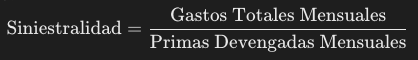

In [ ]:
# Crear un mapeo de 'type_status_id' a 'name'
status_mapping = status_df.set_index('id')['name'].to_dict()

# Añadir la columna 'status_name' a 'service_df' usando el mapeo
service_df['status_name'] = service_df['type_status_id'].map(status_mapping)
service_df['coverage_name'] = service_df['coverage_id'].map(status_mapping)

# Filtrar registros con 'amount' no nulo y donde 'status_name' no es 'No Aplica'
# falta corregir que si se use para el analisis, pero no se aplique deducible en 'No aplica' y coverage id
filtered_df = service_df[service_df['amount'].notna()].copy()

# Extraer el mes de la columna 'created_at'
filtered_df['month'] = pd.to_datetime(filtered_df['created_at']).dt.month

# Aplicar el deducible cuando sea aplicable
def apply_deductible(row):
    # Verificar si el estado es 'No Aplica' o si 'coverage_id' no existe
    if row['status_name'] == 'No Aplica' or 'coverage_id' not in row or pd.isna(row['coverage_id']):
        return row['amount']

    # Si status_name es 'No Aplica' y deductible es True, aplicar el deducible
    if row['deductible'] and row['coverage_name'] in ['DM', 'Robo total', 'RT']:
        # Asumimos un deducible del 5% sobre 100k del valor comercial del auto
        deductible = 0.05 * 100000
        return row['amount'] + deductible if row['amount'] < 0 else row['amount']

    return row['amount']

# Aplicar la función al DataFrame
filtered_df['amount_final'] = filtered_df.apply(apply_deductible, axis=1)

# Filtrar los valores extremos (aumenta mucho el promedio)
filtered_df_clean = filtered_df[(filtered_df['amount_final'] > -1e6) & (filtered_df['amount_final'] < 1e6)]

# Calcular los gastos mensuales agrupados por mes
monthly_expenses = filtered_df_clean.groupby('month')['amount_final'].sum()

# Imprimir resultados
print("Gastos mensuales agrupados por mes:")
print(monthly_expenses)

monthly_income = 200000

#Siniestralidad mensual
siniestralidad_mensual = monthly_expenses / monthly_income
print("Siniestralidad mensual:")
print(siniestralidad_mensual)

Gastos mensuales agrupados por mes:
month
6      1746770.0
7     -1266451.0
8    -17039981.0
9     -7544585.0
10   -29299500.0
11    -6108900.0
Name: amount_final, dtype: float64
Siniestralidad mensual:
month
6       8.733850
7      -6.332255
8     -85.199905
9     -37.722925
10   -146.497500
11    -30.544500
Name: amount_final, dtype: float64


In [ ]:
# Relacionar claims con people en base a people_id
services_with_people = pd.merge(service_df, people_df, left_on='people_id', right_on='id', how='inner')

# Contar la cantidad de siniestros por usuario
siniestros_por_usuario = services_with_people.groupby('id_y')['id_x'].count()  # 'id_y' es el id del usuario, 'id_x' es el id del siniestro

# Encontrar usuarios con mayor y menor cantidad de siniestros
max_siniestros_usuario = siniestros_por_usuario.idxmax()
min_siniestros_usuario = siniestros_por_usuario.idxmin()

max_siniestros = siniestros_por_usuario.max()
min_siniestros = siniestros_por_usuario.min()

# Obtener los nombres, apellidos, y IDs de los usuarios con mayor y menor siniestralidad
max_usuario_info = people_df.loc[people_df['id'] == max_siniestros_usuario, ['id', 'first_name', 'first_last_name']].iloc[0]
min_usuario_info = people_df.loc[people_df['id'] == min_siniestros_usuario, ['id', 'first_name', 'first_last_name']].iloc[0]

# Mostrar resultados
print(f"Usuario con mayor cantidad de siniestros: ID {max_usuario_info['id']}, {max_usuario_info['first_name']} {max_usuario_info['first_last_name']}, Cantidad: {max_siniestros}")
print(f"Usuario con menor cantidad de siniestros: ID {min_usuario_info['id']}, {min_usuario_info['first_name']} {min_usuario_info['first_last_name']}, Cantidad: {min_siniestros}")

Usuario con mayor cantidad de siniestros: ID 0188d449-ef80-70e6-a2a9-f292f34c705d, Homero Simpson, Cantidad: 17
Usuario con menor cantidad de siniestros: ID 0188b6c3-f2b0-7b44-99fb-0d8a80ea2b0b, Mario Alberto Zolano, Cantidad: 1


In [ ]:
# Función para calcular el rango etario
def calculate_age_group(birthdate):
    # Convertir la fecha de nacimiento a año
    birth_year = pd.to_datetime(birthdate).year
    # Calcular la edad
    current_year = pd.Timestamp.now().year
    age = current_year - birth_year

    # Determinar el rango etario
    if age <= 25:
        return '18-25'
    elif age <= 35:
        return '26-35'
    elif age <= 45:
        return '36-45'
    elif age <= 55:
        return '46-55'
    else:
        return '56+'

# Filtrar usuarios con fecha de nacimiento hasta 2007(no otorgan carnet de conducir, a personas menores del 2007) y eliminar valores NaN o null
people_df_filtered = people_df[pd.to_datetime(people_df['birthdate'], errors='coerce').notna()]
people_df_filtered = people_df_filtered[pd.to_datetime(people_df_filtered['birthdate']).dt.year <= 2007]

# Relacionar tablas
services_with_people = pd.merge(service_df, people_df_filtered, left_on='people_id', right_on='id', how='inner')
services_with_claims = pd.merge(services_with_people, claim_df, left_on='claim_id', right_on='id', how='inner')

# Extraer el partner de policy_number
services_with_claims['partner'] = services_with_claims['policy_number'].str[:2]

# Aplicar la función para obtener el amount_final
services_with_claims['amount_final'] = services_with_claims.apply(apply_deductible, axis=1)

# Agrupar por partner y calcular el gasto total y el número de siniestros
total_expenses_per_partner = services_with_claims.groupby('partner')['amount_final'].sum()
siniestros_per_partner = services_with_claims.groupby('partner')['id_x'].count()

# Calcular la severidad promedio por partner
severidad_promedio_per_partner = total_expenses_per_partner / siniestros_per_partner

# Encontrar el partner con mayor y menor siniestralidad
max_siniestros_partner = siniestros_per_partner.idxmax()
min_siniestros_partner = siniestros_per_partner.idxmin()

max_siniestros = siniestros_per_partner.max()
min_siniestros = siniestros_per_partner.min()

# Encontrar la severidad promedio para los partners con mayor y menor siniestralidad
max_severidad_promedio = severidad_promedio_per_partner[max_siniestros_partner]
min_severidad_promedio = severidad_promedio_per_partner[min_siniestros_partner]

# Mostrar resultados
print(f"Partner con mayor cantidad de siniestros: {max_siniestros_partner}, Cantidad: {max_siniestros}")
print(f"Severidad promedio del partner con mayor siniestralidad: {max_severidad_promedio}")

print(f"Partner con menor cantidad de siniestros: {min_siniestros_partner}, Cantidad: {min_siniestros}")
print(f"Severidad promedio del partner con menor siniestralidad: {min_severidad_promedio}")

print("\nNúmero de siniestros por partner:")
print(siniestros_per_partner)

Partner con mayor cantidad de siniestros: AE, Cantidad: 316
Severidad promedio del partner con mayor siniestralidad: -7972328.901898734
Partner con menor cantidad de siniestros: WO, Cantidad: 8
Severidad promedio del partner con menor siniestralidad: -150010.0

Número de siniestros por partner:
partner
AE    316
CH     78
DA     27
IT     54
KV    166
SE     16
WO      8
Name: id_x, dtype: int64


In [ ]:
# filtramos datos nulos
services_with_claims_cleaned = services_with_claims[services_with_claims['amount'].notna()].copy()

# Calcular el rango etario de los usuarios siniestrados
services_with_claims_cleaned['age_group'] = services_with_claims_cleaned['birthdate'].apply(calculate_age_group)

# Calcular los gastos totales por grupo etario
total_expenses_per_age_group = services_with_claims_cleaned.groupby('age_group')['amount_final'].sum()

# Calcular el número de siniestros por grupo etario
siniestros_per_age_group = services_with_claims_cleaned.groupby('age_group')['id_x'].count()

# Calcular la severidad promedio
severidad_promedio_age_group = total_expenses_per_age_group / siniestros_per_age_group

# Encontrar el rango etario con mayor y menor siniestralidad
max_siniestros_age_group = siniestros_per_age_group.idxmax()
min_siniestros_age_group = siniestros_per_age_group.idxmin()

max_siniestros = siniestros_per_age_group.max()
min_siniestros = siniestros_per_age_group.min()

# Encontrar la severidad promedio para los rangos etarios con mayor y menor siniestralidad
max_severidad_promedio = severidad_promedio_age_group[max_siniestros_age_group]
min_severidad_promedio = severidad_promedio_age_group[min_siniestros_age_group]

# Mostrar resultados
print(f"Rango etario con mayor cantidad de siniestros: {max_siniestros_age_group}, Cantidad: {max_siniestros}")
print(f"Severidad promedio del rango etario con mayor siniestralidad: {max_severidad_promedio}")

print(f"Rango etario con menor cantidad de siniestros: {min_siniestros_age_group}, Cantidad: {min_siniestros}")
print(f"Severidad promedio del rango etario con menor siniestralidad: {min_severidad_promedio}")

print("\nNúmero de siniestros por rango etario:")
print(siniestros_per_age_group)

Rango etario con mayor cantidad de siniestros: 26-35, Cantidad: 135
Severidad promedio del rango etario con mayor siniestralidad: -10326093.066666666
Rango etario con menor cantidad de siniestros: 56+, Cantidad: 2
Severidad promedio del rango etario con menor siniestralidad: 10000.0

Número de siniestros por rango etario:
age_group
18-25     96
26-35    135
36-45     30
46-55     88
56+        2
Name: id_x, dtype: int64


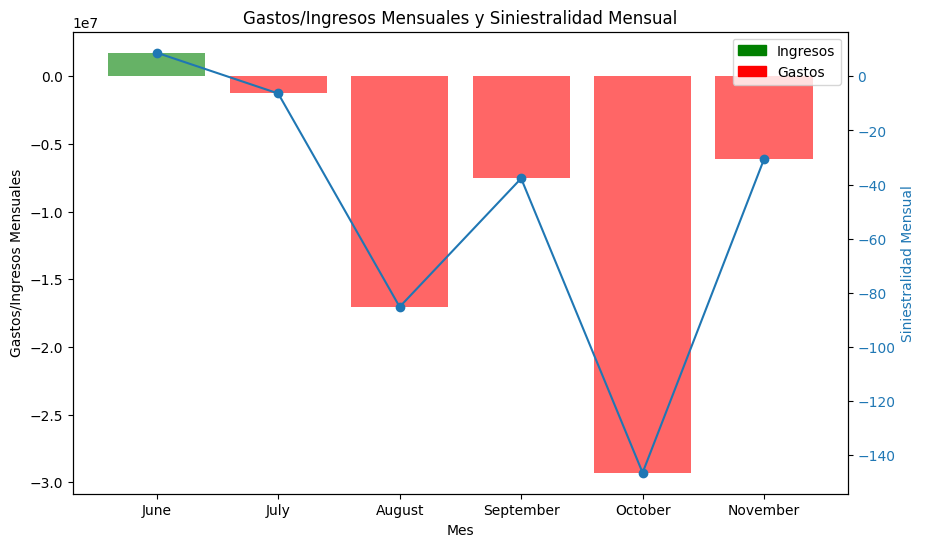

In [ ]:
import matplotlib.pyplot as plt
import calendar
import matplotlib.patches as mpatches
import seaborn as sns

# Mapeo de números de meses a nombres
month_names = [calendar.month_name[month] for month in monthly_expenses.index]

# Crear una figura y ejes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Colores basados en si es ingreso (positivo) o gasto (negativo)
colors = ['green' if value > 0 else 'red' for value in monthly_expenses.values]

# Configuración del primer eje para los gastos e ingresos mensuales
ax1.set_xlabel('Mes')
ax1.set_ylabel('Gastos/Ingresos Mensuales')
ax1.bar(month_names, monthly_expenses.values, color=colors, alpha=0.6)
ax1.tick_params(axis='y')

# Crear un segundo eje para la siniestralidad mensual
ax2 = ax1.twinx()
ax2.set_ylabel('Siniestralidad Mensual', color='tab:blue')
ax2.plot(month_names, siniestralidad_mensual.values, color='tab:blue', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Título del gráfico
plt.title('Gastos/Ingresos Mensuales y Siniestralidad Mensual')

# Añadir simbología
red_patch = mpatches.Patch(color='red', label='Gastos')
green_patch = mpatches.Patch(color='green', label='Ingresos')
plt.legend(handles=[green_patch, red_patch], loc='upper right')

# Mostrar el gráfico
plt.show()


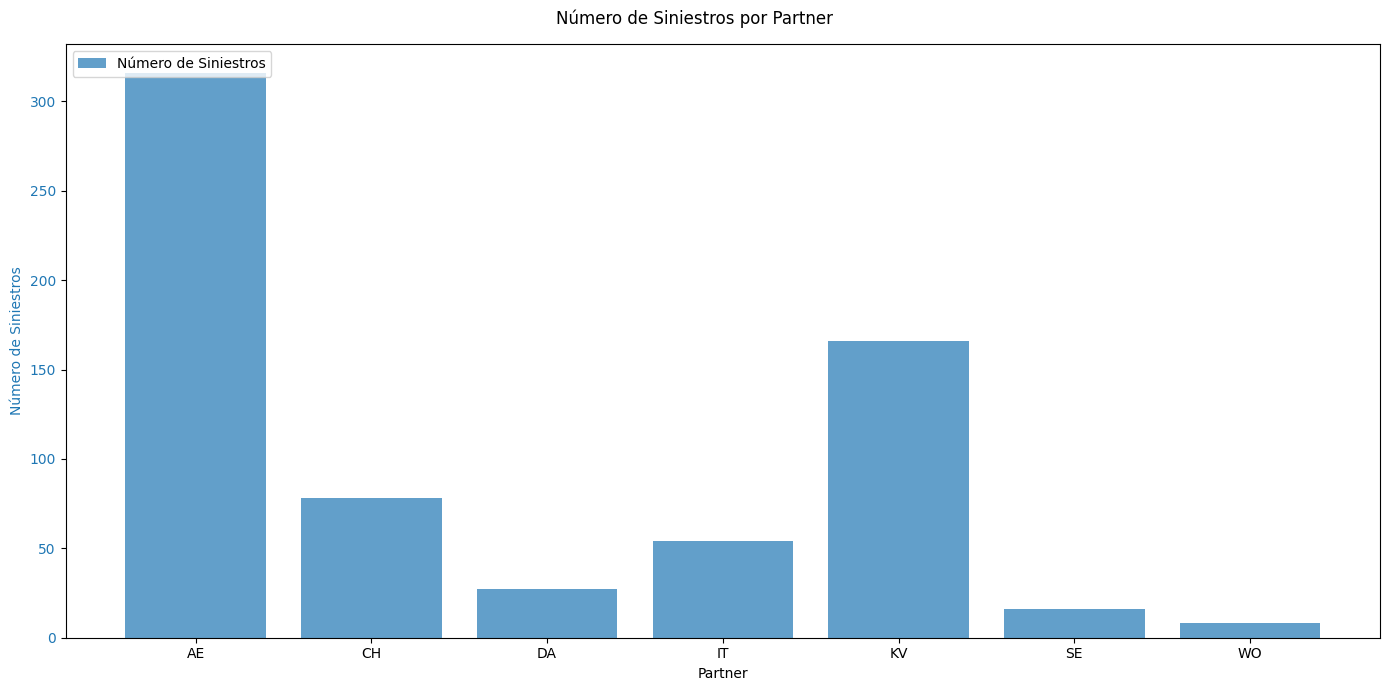

In [ ]:
import matplotlib.pyplot as plt

# Datos para graficar
partners = siniestros_per_partner.index
siniestros = siniestros_per_partner.values
severidad_promedio = severidad_promedio_per_partner.loc[partners].values

# Crear una figura y un conjunto de subplots
fig, ax1 = plt.subplots(figsize=(14, 7))

# Gráfico de número de siniestros por partner
color = 'tab:blue'
ax1.set_xlabel('Partner')
ax1.set_ylabel('Número de Siniestros', color=color)
ax1.bar(partners, siniestros, color=color, alpha=0.7, label='Número de Siniestros')
ax1.tick_params(axis='y', labelcolor=color)


# Títulos y etiquetas
fig.suptitle('Número de Siniestros por Partner')
fig.tight_layout()  # Ajusta el layout para evitar el solapamiento de etiquetas

# Mostrar la leyenda
ax1.legend(loc='upper left')

# Mostrar el gráfico
plt.show()


<ipython-input-9-3c04676769d9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=siniestros_per_age_group.index, y=siniestros_per_age_group.values, palette=colors, ax=ax1)


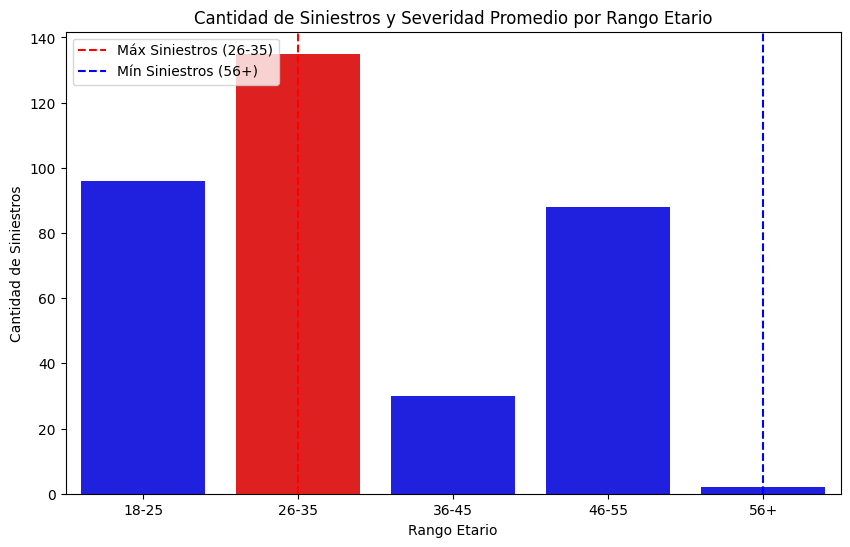

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Colores para el gráfico de barras
colors = ['red' if age_group == max_siniestros_age_group else 'blue' for age_group in siniestros_per_age_group.index]

# Gráfico de barras para la cantidad de siniestros por rango etario
sns.barplot(x=siniestros_per_age_group.index, y=siniestros_per_age_group.values, palette=colors, ax=ax1)
ax1.set_xlabel('Rango Etario')
ax1.set_ylabel('Cantidad de Siniestros')
ax1.set_title('Cantidad de Siniestros y Severidad Promedio por Rango Etario')
ax1.tick_params(axis='y')

# Añadir líneas para destacar el rango etario con mayor y menor siniestralidad
ax1.axvline(max_siniestros_age_group, color='red', linestyle='--', label=f'Máx Siniestros ({max_siniestros_age_group})')
ax1.axvline(min_siniestros_age_group, color='blue', linestyle='--', label=f'Mín Siniestros ({min_siniestros_age_group})')

# Añadir leyenda para colores y líneas
ax1.legend(loc='upper left')

# Mostrar el gráfico
plt.show()

# Respuestas

## ¿Cuál es la siniestralidad mensual de la compañía?

| Mes         | Siniestralidad |
|-------------|----------------|
| Junio       | 8.733850       |
| Julio       | -6.332255      |
| Agosto      | -85.199905     |
| Septiembre  | -37.722925     |
| Octubre     | -146.497500    |
| Noviembre   | -30.544500     |

## Gastos Mensuales

| Mes         | Gastos         |
|-------------|----------------|
| Junio       | 1,746,770.0    |
| Julio       | -1,266,451.0   |
| Agosto      | -17,039,981.0  |
| Septiembre  | -7,544,585.0   |
| Octubre     | -29,299,500.0  |
| Noviembre   | -6,108,900.0   |

## ¿Cuál es la cobertura con mayor y menor cantidad de siniestros?

- **Usuario con mayor cantidad de siniestros**:
  - **ID**: 0188d449-ef80-70e6-a2a9-f292f34c705d
  - **Nombre**: Homero Simpson
  - **Cantidad**: 17

- **Usuario con menor cantidad de siniestros**:
  - **ID**: 0188b6c3-f2b0-7b44-99fb-0d8a80ea2b0b
  - **Nombre**: Mario Alberto Zolano
  - **Cantidad**: 1

## ¿Cuál es el partner con mayor y menor siniestralidad? ¿Cuál es su severidad promedio?

- **Partner con mayor cantidad de siniestros**:
  - **Partner**: AE
  - **Cantidad**: 316
  - **Severidad promedio**: -7,972,328.90

- **Partner con menor cantidad de siniestros**:
  - **Partner**: WO
  - **Cantidad**: 8
  - **Severidad promedio**: -150,010.00

**Número de siniestros por partner**:

| Partner | Número de Siniestros |
|---------|----------------------|
| AE      | 316                  |
| CH      | 78                   |
| DA      | 27                   |
| IT      | 54                   |
| KV      | 166                  |
| SE      | 16                   |
| WO      | 8                    |

## ¿Dentro de qué rango etario se encuentra la mayor y menor cantidad de usuarios siniestrados? ¿Cuál es su severidad promedio?

- **Rango etario con mayor cantidad de siniestros**:
  - **Rango**: 26-35
  - **Cantidad**: 135
  - **Severidad promedio**: -10,326,093.07

- **Rango etario con menor cantidad de siniestros**:
  - **Rango**: 56+
  - **Cantidad**: 2
  - **Severidad promedio**: 10,000.00

**Número de siniestros por rango etario**:

| Rango Etario | Número de Siniestros |
|--------------|----------------------|
| 18-25        | 96                   |
| 26-35        | 135                  |
| 36-45        | 30                   |
| 46-55        | 88                   |
| 56+          | 2                    |
